In [1]:
## Necessary packages
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import logging
tf.get_logger().setLevel(logging.ERROR)

# 1. SeriesGan model
from seriesgan import seriesgan

# 2. Data loading
from data_loading import real_data_loading, sine_data_generation
# 3. Metrics
from metrics.discriminative_metrics import discriminative_score_metrics
from metrics.predictive_metrics import predictive_score_metrics
from metrics.visualization_metrics import visualization

2025-03-29 22:06:30.476201: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-29 22:06:30.485638: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-29 22:06:30.523370: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-29 22:06:30.523393: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-29 22:06:30.523418: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [3]:
original_data = []

seq_len = 24
data_name = 'stock'
original_data = real_data_loading(data_name, seq_len)

print(data_name + ' dataset is ready.')

stock dataset is ready.


In [88]:
## Newtork parameters
parameters = dict()

parameters['hidden_dim'] = 'same'
parameters['iterations'] = 2000
parameters['batch_size'] = 128
parameters['num_layer'] = 4

In [89]:
seriesgan_result = seriesgan(original_data, parameters, 'same')

Start Autoencoder Training for Loss
step: 0/2000, AE_loss: 0.1542
step: 1000/2000, AE_loss: 0.0013
step: 1998/2000, AE_loss: 0.0011
Finish Autoencoder Training for Loss
Start Embedding Network Training
step: 0/2000, AE_loss: 0.3699, AE_D_loss: 1.0307
step: 1000/2000, AE_loss: 0.0363, AE_D_loss: 0.4994
step: 1998/2000, AE_loss: 0.0214, AE_D_loss: 0.4976
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/2000, S_loss: 0.1397
step: 1000/2000, S_loss: 0.0007
step: 1999/2000, S_loss: 0.0005
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/2000, D_loss: 0.9512, G_loss: 11.2969, G_loss_u: 2.4377, G_loss_s: 0.0006, G_loss_ts: 0.1997, AE_loss: 0.0889, AE_D_loss: 1.0088
step: 1000/2000, D_loss: 0.5052, G_loss: 2.8781, G_loss_u: 1.771, G_loss_s: 0.0004, G_loss_ts: 0.0037, AE_loss: 0.0107, AE_D_loss: 0.7658
step: 1999/2000, D_loss: 0.6652, G_loss: 2.6065, G_loss_u: 1.4151, G_loss_s: 0.0004, G_loss_ts: 0.0025, AE_loss: 0.0081, AE_D_loss: 0.9586


In [90]:
ori_data = pd.read_csv('data/stock_data.csv')

In [91]:
ori_data.shape

(3685, 6)

In [92]:
scaler = MinMaxScaler()
scaler.fit(ori_data)

MinMaxScaler()

In [93]:
seriesgan_result.shape

(3661, 24, 6)

In [94]:
len(generated_data_chunks)

3661

In [95]:
reconstructed_data = np.zeros((3661, 6))  # Target shape
count = np.zeros((3661, 1))  # Count occurrences (shape (3661,1) to avoid broadcast issues)

# Step 5: Reconstruct original shape (3661, 6) by averaging overlapping chunk values
for i in range(3661):  # Iterate over each chunk
    for j in range(24):  # Iterate over each time step in the chunk
        if i + j < 3661:
            reconstructed_data[i + j] += seriesgan_result[i, j]  # Add each feature value
            count[i + j] += 1  # Track how many times each row is summed

# Step 6: Compute the average where overlaps occur
reconstructed_data /= count  # Element-wise division to normalize overlapping entries

# Step 7: Apply inverse transformation using the fitted scaler
generated_data_restored = scaler.inverse_transform(reconstructed_data)  # Shape: (3661, 6)

# Convert to DataFrame for visualization
df_generated = pd.DataFrame(generated_data_restored, columns=[f"feature_{i}" for i in range(6)])

In [96]:
df_generated

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5
0,368.508980,363.550241,367.669326,368.520105,371.916361,5.004297e+06
1,313.808385,310.379735,311.018953,312.596177,315.768920,6.466816e+06
2,269.094184,268.070521,266.643611,267.674452,270.484838,1.052451e+07
3,309.532533,309.865871,308.919827,309.320920,312.913545,9.476790e+06
4,354.546310,353.962536,353.479679,354.491159,357.701308,6.589061e+06
...,...,...,...,...,...,...
3656,440.528934,443.410142,434.020297,438.348959,439.481918,7.480836e+06
3657,460.340760,462.729925,453.577087,458.179057,458.903569,6.929197e+06
3658,488.116112,489.692237,481.116070,486.136817,486.575958,6.319659e+06
3659,486.724675,488.005770,479.992291,484.938516,485.460284,6.478454e+06


<Axes: >

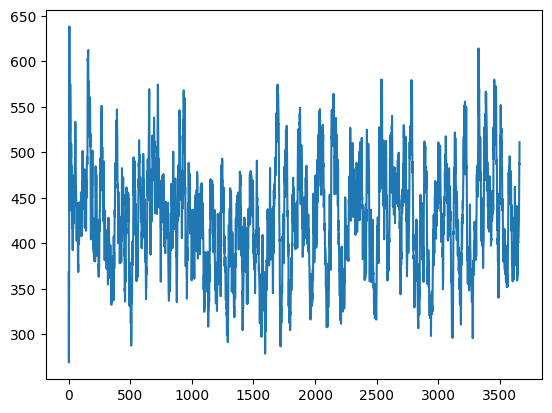

In [100]:
df_generated["feature_0"].plot()

<Axes: >

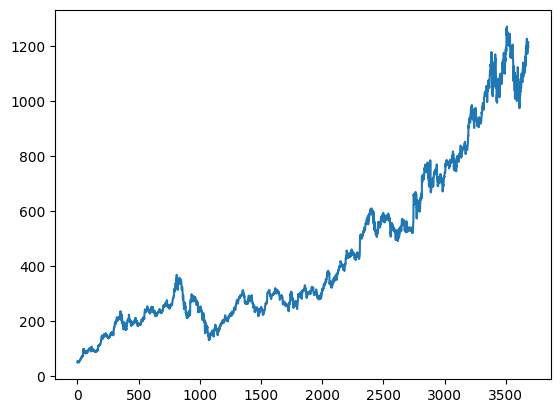

In [102]:
ori_data["Open"].plot()

In [103]:
df_generated.to_csv("test.csv", index = False)

In [104]:
len(seriesgan_result)

3661